# Does the linear regression make sense?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions as f
import random

In [31]:
import scipy.stats as st

def get_pvalue(count, permut):
    # calculating p-value without first and last group, since std is 0 here. 
    z_score = (np.array(count['matches'][1:-1])-np.array(permut['mean'][1:-1]))/np.array(permut['std'][1:-1])


    #cumulative distribution function
    # --> not sure if I should take 1- ? for righttailed test? yes. or just use sf.
    p_values = st.norm.sf(z_score)


    # significance 5%
    top = st.norm.ppf(.975)
    bottom = st.norm.ppf(.025)
    
    return (p_values, z_score)

In [66]:
lin = pd.read_pickle('linearQuick/Coefs.pkl')
we = f.help_pivot_to_df(lin)

,target,predictors,coefficients
0,Mrpl15,Klf2,-0.093016
1,Mrpl15,Mcm5,0.120971
2,Mrpl15,Mcm6,-0.040343
3,Mrpl15,Mcm3,-0.141216
4,Mrpl15,Ung,0.046575
...,...,...,...
1674585,Erdr1,Tnfrsf9,0.057390
1674586,Erdr1,Top2a,-0.233010
1674587,Erdr1,Ubc,0.028077
1674588,Erdr1,Vim,0.005645


# Permutations

In [7]:
# import permutation scores
percentages = list(np.arange(0, 1.02, 0.02))

In [68]:
# import results from pca model
pca_permut160 = pd.read_pickle('pca/permutations.pkl')

pca_count160 = pd.DataFrame(pd.read_pickle('pca/count.pkl'), columns = ['matches'])
pca_permut160['percentages'], pca_count160['percentages']=percentages, percentages

pca_p_values, pca_z_scores = get_pvalue(count = pca_count160, permut = pca_permut160)

<ipython-input-31-a809863ac0a1>:5: RuntimeWarning: invalid value encountered in true_divide
  z_score = (np.array(count['matches'][1:-1])-np.array(permut['mean'][1:-1]))/np.array(permut['std'][1:-1])


In [76]:
pd.read_pickle('pca/gene_impact.pkl')


,target,predictors,coefficients
0,0,Klf2,-0.003409
1,0,Mcm5,-0.004352
2,0,Mcm6,-0.021431
3,0,Mcm3,-0.022871
4,0,Ung,-0.019562
...,...,...,...
1685675,1108,Tnfrsf9,0.086649
1685676,1108,Top2a,-0.036887
1685677,1108,Ubc,0.021339
1685678,1108,Vim,0.035504


In [33]:
# import results from pca model
pca_permut160 = pd.read_pickle('pca/permutations.pkl')

pca_impact160 = pd.DataFrame(pd.read_pickle('pca/count_gene_impact.pkl'), columns = ['matches'])
pca_permut160['percentages'], pca_count160['percentages']=percentages, percentages

imp_pca_p_values, imp_pca_z_scores = get_pvalue(count = pca_impact160, permut = pca_permut160)

In [34]:
# import results from pls model
pls_permut160 = pd.read_pickle('pls/permutations.pkl')

pls_count160 = pd.DataFrame(pd.read_pickle('pls/count.pkl'), columns = ['matches'])
pls_permut160['percentages'], pls_count160['percentages']=percentages, percentages

pls_p_values, pls_z_scores = get_pvalue(count = pls_count160, permut = pls_permut160)

pls_full using all components is way worse. --> maybe I can optimize this. 

In [46]:
# import results from linear model
linear_permut160 = pd.read_pickle('linearQuick/permutations.pkl')

linear_count160 = pd.DataFrame(pd.read_pickle('linearQuick/count.pkl'), columns = ['matches'])
linear_permut160['percentages'], linear_count160['percentages']=percentages, percentages

linear_p_values, linear_z_scores = get_pvalue(count = linear_count160, permut = linear_permut160)

In [48]:
# import results from ridge model
ridge_permut160 = pd.read_pickle('ridge/permutations.pkl')

ridge_count160 = pd.DataFrame(pd.read_pickle('ridge/count.pkl'), columns = ['matches'])
ridge_permut160['percentages'], ridge_count160['percentages']=percentages, percentages

ridge_p_values, ridge_z_scores = get_pvalue(count = ridge_count160, permut = ridge_permut160)

In [36]:
# import results from rf model
rf_permut160 = pd.read_pickle('rf/permutations.pkl')

rf_count160 = pd.DataFrame(pd.read_pickle('rf/count.pkl'), columns = ['matches'])
rf_permut160['percentages'], rf_count160['percentages']=percentages, percentages

rf_p_values, rf_z_scores = get_pvalue(count = rf_count160, permut = rf_permut160)

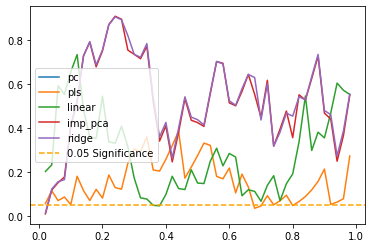

In [79]:
ax = sns.lineplot(x = percentages[1:-1], y = pca_p_values, label = 'pc')
sns.lineplot(x = percentages[1:-1], y = pls_p_values, label = 'pls')
sns.lineplot(x = percentages[1:-1], y = linear_p_values, label = 'linear')
#sns.lineplot(x = percentages[1:-1], y = rf_p_values, label = 'rf')
sns.lineplot(x = percentages[1:-1], y = imp_pca_p_values, label = 'imp_pca')
sns.lineplot(x = percentages[1:-1], y = ridge_p_values, label = 'ridge')
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()

Text(0.5, 1.0, 'Number of matches with increasing coefficient values')

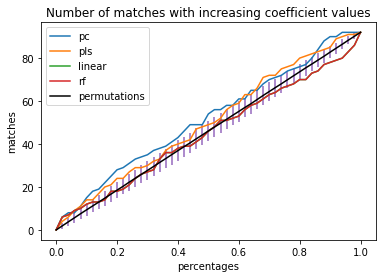

In [44]:
ax = sns.lineplot(data = pca_count160, x='percentages', y = 'matches',label='pc')
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = linear_count160, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = rf_count160, x='percentages', y = 'matches',label='rf')
ax = sns.lineplot(data = pca_permut160, x ='percentages', y = 'mean', label='permutations', color='black')
ax.errorbar(pca_permut160['percentages'], pca_permut160['mean'], yerr=pca_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Number of matches with increasing coefficient values')


take ratio of matches and mean value as null --> plot ratio

Text(0.5, 1.0, 'PC Regression')

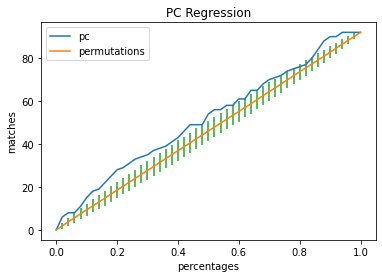

In [59]:
ax = sns.lineplot(data = pca_count160, x='percentages', y = 'matches',label='pc')
ax = sns.lineplot(data = pca_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pca_permut160['percentages'], pca_permut160['mean'], yerr=pca_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PC Regression')

Text(0.5, 1.0, 'Linear Regression')

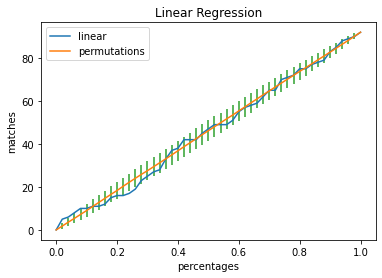

In [56]:
ax = sns.lineplot(data = linear_count160, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160['percentages'], linear_permut160['mean'], yerr=linear_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

Text(0.5, 1.0, 'ridge Regression')

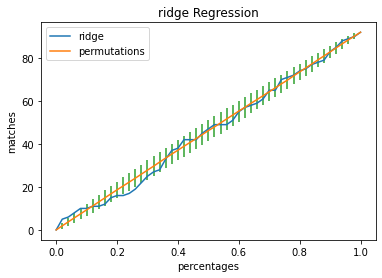

In [57]:
ax = sns.lineplot(data = ridge_count160, x='percentages', y = 'matches',label='ridge')
ax = sns.lineplot(data = ridge_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(ridge_permut160['percentages'], ridge_permut160['mean'], yerr=ridge_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('ridge Regression')

In [ ]:
ax = sns.lineplot(data = pls_count160, x='percentages', y = 'matches',label='pls')
ax = sns.lineplot(data = pls_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(pls_permut160['percentages'], pls_permut160['mean'], yerr=pls_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('PLS Regression')

Text(0.5, 1.0, 'rf Regression')

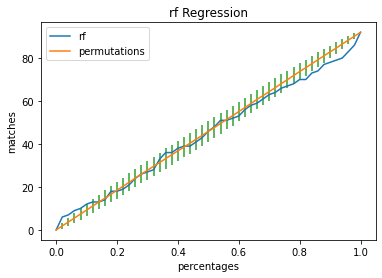

In [54]:
ax = sns.lineplot(data = rf_count160, x='percentages', y = 'matches',label='rf')
ax = sns.lineplot(data = rf_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(rf_permut160['percentages'], rf_permut160['mean'], yerr=rf_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('rf Regression')

In [ ]:
ax = sns.lineplot(data = rf_count160, x='percentages', y = 'matches',label='rf')
ax = sns.lineplot(data = rf_permut160, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(rf_permut160['percentages'], rf_permut160['mean'], yerr=rf_permut160['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('rf Regression')

#### There are 416 matches from the RegNet database for the 160 relevant genes, looking at predictors and targets. Of those, 91 are also represented in our set of 1109*152=167,459 pairs. 

## Find largest probability for significant pairs

In [ ]:
sorted(list(zip(pca_p_values, percentages))[1:])

So, the smallest p-values, without choosing all pairs are at about 0.18 or 0.16. --> will start with 0.18

# Clusters

Clusters: took 4:45h

In [85]:
# import results from linear model
linear_permut160_00 = pd.read_pickle('linearCluster/cluster_0/permutations.pkl')

linear_count160_00 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_0/count.pkl'), columns = ['matches'])
linear_permut160_00['percentages'], linear_count160_00['percentages']=percentages, percentages

linear_p_values_00, linear_z_scores_00 = get_pvalue(count = linear_count160_00, permut = linear_permut160_00)

Text(0.5, 1.0, 'Linear Regression')

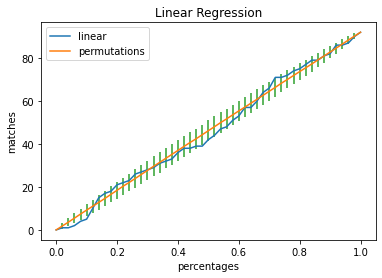

In [83]:
ax = sns.lineplot(data = linear_count160_00, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_00, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_00['percentages'], linear_permut160_00['mean'], yerr=linear_permut160_00['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

In [89]:
# import results from linear model
linear_permut160_01 = pd.read_pickle('linearCluster/cluster_1/permutations.pkl')

linear_count160_01 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_1/count.pkl'), columns = ['matches'])
linear_permut160_01['percentages'], linear_count160_01['percentages']=percentages, percentages

linear_p_values_01, linear_z_scores_01 = get_pvalue(count = linear_count160_01, permut = linear_permut160_01)

Text(0.5, 1.0, 'Linear Regression')

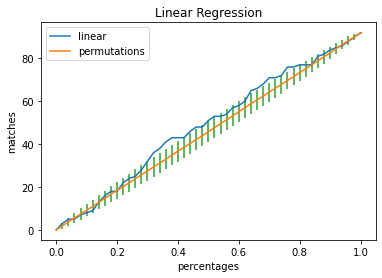

In [90]:
ax = sns.lineplot(data = linear_count160_01, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_01, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_01['percentages'], linear_permut160_01['mean'], yerr=linear_permut160_01['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

In [91]:
# import results from linear model
linear_permut160_02 = pd.read_pickle('linearCluster/cluster_2/permutations.pkl')

linear_count160_02 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_2/count.pkl'), columns = ['matches'])
linear_permut160_02['percentages'], linear_count160_02['percentages']=percentages, percentages

linear_p_values_02, linear_z_scores_02 = get_pvalue(count = linear_count160_02, permut = linear_permut160_02)

Text(0.5, 1.0, 'Linear Regression')

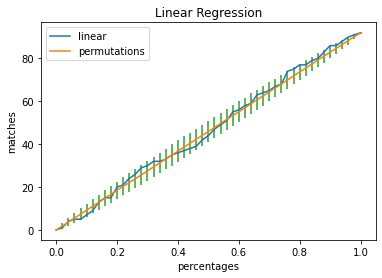

In [92]:
ax = sns.lineplot(data = linear_count160_02, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_02, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_02['percentages'], linear_permut160_02['mean'], yerr=linear_permut160_02['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

In [93]:
# import results from linear model
linear_permut160_03 = pd.read_pickle('linearCluster/cluster_3/permutations.pkl')

linear_count160_03 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_3/count.pkl'), columns = ['matches'])
linear_permut160_03['percentages'], linear_count160_03['percentages']=percentages, percentages

linear_p_values_03, linear_z_scores_03 = get_pvalue(count = linear_count160_03, permut = linear_permut160_03)

Text(0.5, 1.0, 'Linear Regression')

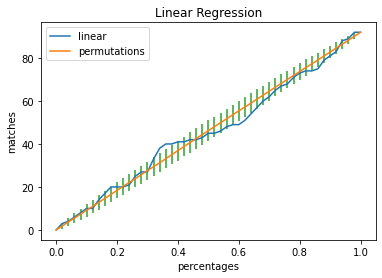

In [94]:
ax = sns.lineplot(data = linear_count160_03, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_03, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_03['percentages'], linear_permut160_03['mean'], yerr=linear_permut160_03['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

In [95]:
# import results from linear model
linear_permut160_04 = pd.read_pickle('linearCluster/cluster_4/permutations.pkl')

linear_count160_04 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_4/count.pkl'), columns = ['matches'])
linear_permut160_04['percentages'], linear_count160_04['percentages']=percentages, percentages

linear_p_values_04, linear_z_scores_04 = get_pvalue(count = linear_count160_04, permut = linear_permut160_04)

Text(0.5, 1.0, 'Linear Regression')

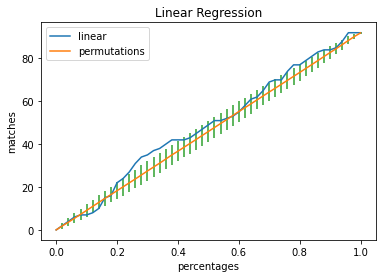

In [96]:
ax = sns.lineplot(data = linear_count160_04, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_04, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_04['percentages'], linear_permut160_04['mean'], yerr=linear_permut160_04['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

In [97]:
# import results from linear model
linear_permut160_05 = pd.read_pickle('linearCluster/cluster_5/permutations.pkl')

linear_count160_05 = pd.DataFrame(pd.read_pickle('linearCluster/cluster_5/count.pkl'), columns = ['matches'])
linear_permut160_05['percentages'], linear_count160_05['percentages']=percentages, percentages

linear_p_values_05, linear_z_scores_05 = get_pvalue(count = linear_count160_05, permut = linear_permut160_05)

Text(0.5, 1.0, 'Linear Regression')

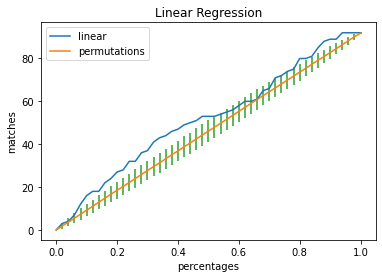

In [98]:
ax = sns.lineplot(data = linear_count160_05, x='percentages', y = 'matches',label='linear')
ax = sns.lineplot(data = linear_permut160_05, x ='percentages', y = 'mean', label='permutations')
ax.errorbar(linear_permut160_05['percentages'], linear_permut160_05['mean'], yerr=linear_permut160_05['std'], fmt=' ', zorder=-1)
ax.legend()
ax.set_title('Linear Regression')

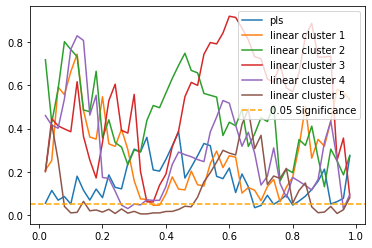

In [99]:
ax = sns.lineplot(x = percentages[1:-1], y = pls_p_values, label = 'pls')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_01, label = 'linear cluster 1')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_02, label = 'linear cluster 2')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_03, label = 'linear cluster 3')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_04, label = 'linear cluster 4')
sns.lineplot(x = percentages[1:-1], y = linear_p_values_05, label = 'linear cluster 5')
ax.axhline(0.05, ls = '--', c='orange', label = '0.05 Significance')
ax.legend()

# CV Scores

In [ ]:
pca_scores160 = pd.read_pickle('pca/Scores.pkl')
pls_scores160 = pd.read_pickle('pls/Scores.pkl')
linear_scores160 = pd.read_pickle('linearQuick/Scores.pkl')

In [ ]:
ax = sns.histplot(pca_scores160[['test_r2', 'train_r2']], label='pca')
sns.histplot(linear_scores160[['test_r2', 'train_r2']], label='linear')
sns.histplot(pls_scores160[['test_r2', 'train_r2']], label='pls')
ax.legend()